## Dataset Information
The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

## Download Dataset

In [1]:
!curl --ssl-no-revoke -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 3232k    0     0  8670k      0  0:01:32 --:--:--  0:01:32 8758k
  1  786M    1 14.3M    0     0  10.4M      0  0:01:15  0:00:01  0:01:14 10.4M
  3  786M    3 24.2M    0     0  10.2M      0  0:01:17  0:00:02  0:01:15 10.2M
  4  786M    4 35.2M    0     0  10.4M      0  0:01:15  0:00:03  0:01:12 10.4M
  5  786M    5 46.8M    0     0  10.6M      0  0:01:13  0:00:04  0:01:09 10.7M
  7  786M    7 57.9M    0     0  10.7M      0  0:01:13  0:00:05  0:01:08 10.9M
  8  786M    8 68.9M    0     0  10.8M      0  0:01:12  0:00:06  0:01:06 10.9M
 10  786M   10 80.2M    0     0  10.8M      0  0:01:12  0:00:07  0:01:05 11.2M
 11  786M   11 91.5M    0     0  10.9M      0  0:01:11  0:00:08  0:01:03 11.2M
 13  786M   13  103M    0     0  10.9M      0  0:01

## Unzip the Dataset

In [2]:
import zipfile
import os

zip_file_path = 'kagglecatsanddogs_5340.zip'
extract_to_path = 'cats_and_dogs'

os.makedirs(extract_to_path, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
    print(f"Dateien wurden erfolgreich nach {extract_to_path} entpackt.")
except zipfile.BadZipFile:
    print("Die Datei ist entweder keine gültige ZIP-Datei oder sie ist beschädigt.")

Dateien wurden erfolgreich nach cats_and_dogs entpackt.


## Import Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random
import tensorflow as tf
import PIL
import seaborn as sns
from tensorflow import keras

# tf.debugging.set_log_device_placement(True)
warnings.filterwarnings('ignore')
print(tf.__version__)
print(keras.__version__)


2.17.0
3.6.0


## Create Dataframe for Input and Output

In [4]:
input_path = []
label = []

for class_name in os.listdir("cats_and_dogs/PetImages"):
  for path in os.listdir("cats_and_dogs/PetImages/" + class_name):
    if class_name == 'Cat':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("cats_and_dogs/PetImages", class_name, path))
print(input_path[0], label[0])

cats_and_dogs/PetImages\Cat\0.jpg 0


### Delete Invalid Images

In [5]:
for image in input_path:
  try:
    PIL.Image.open(image)
  except:
    print(image)
    os.remove(image)

cats_and_dogs/PetImages\Cat\666.jpg
cats_and_dogs/PetImages\Cat\Thumbs.db
cats_and_dogs/PetImages\Dog\11702.jpg
cats_and_dogs/PetImages\Dog\Thumbs.db


### Create Dataframe

In [6]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop = True)
df.head()

images  label
0   cats_and_dogs/PetImages\Dog\6519.jpg      1
1  cats_and_dogs/PetImages\Cat\10169.jpg      0
2   cats_and_dogs/PetImages\Dog\8263.jpg      1
3   cats_and_dogs/PetImages\Dog\2292.jpg      1
4   cats_and_dogs/PetImages\Dog\3396.jpg      1

## Exploratory Data Analysis

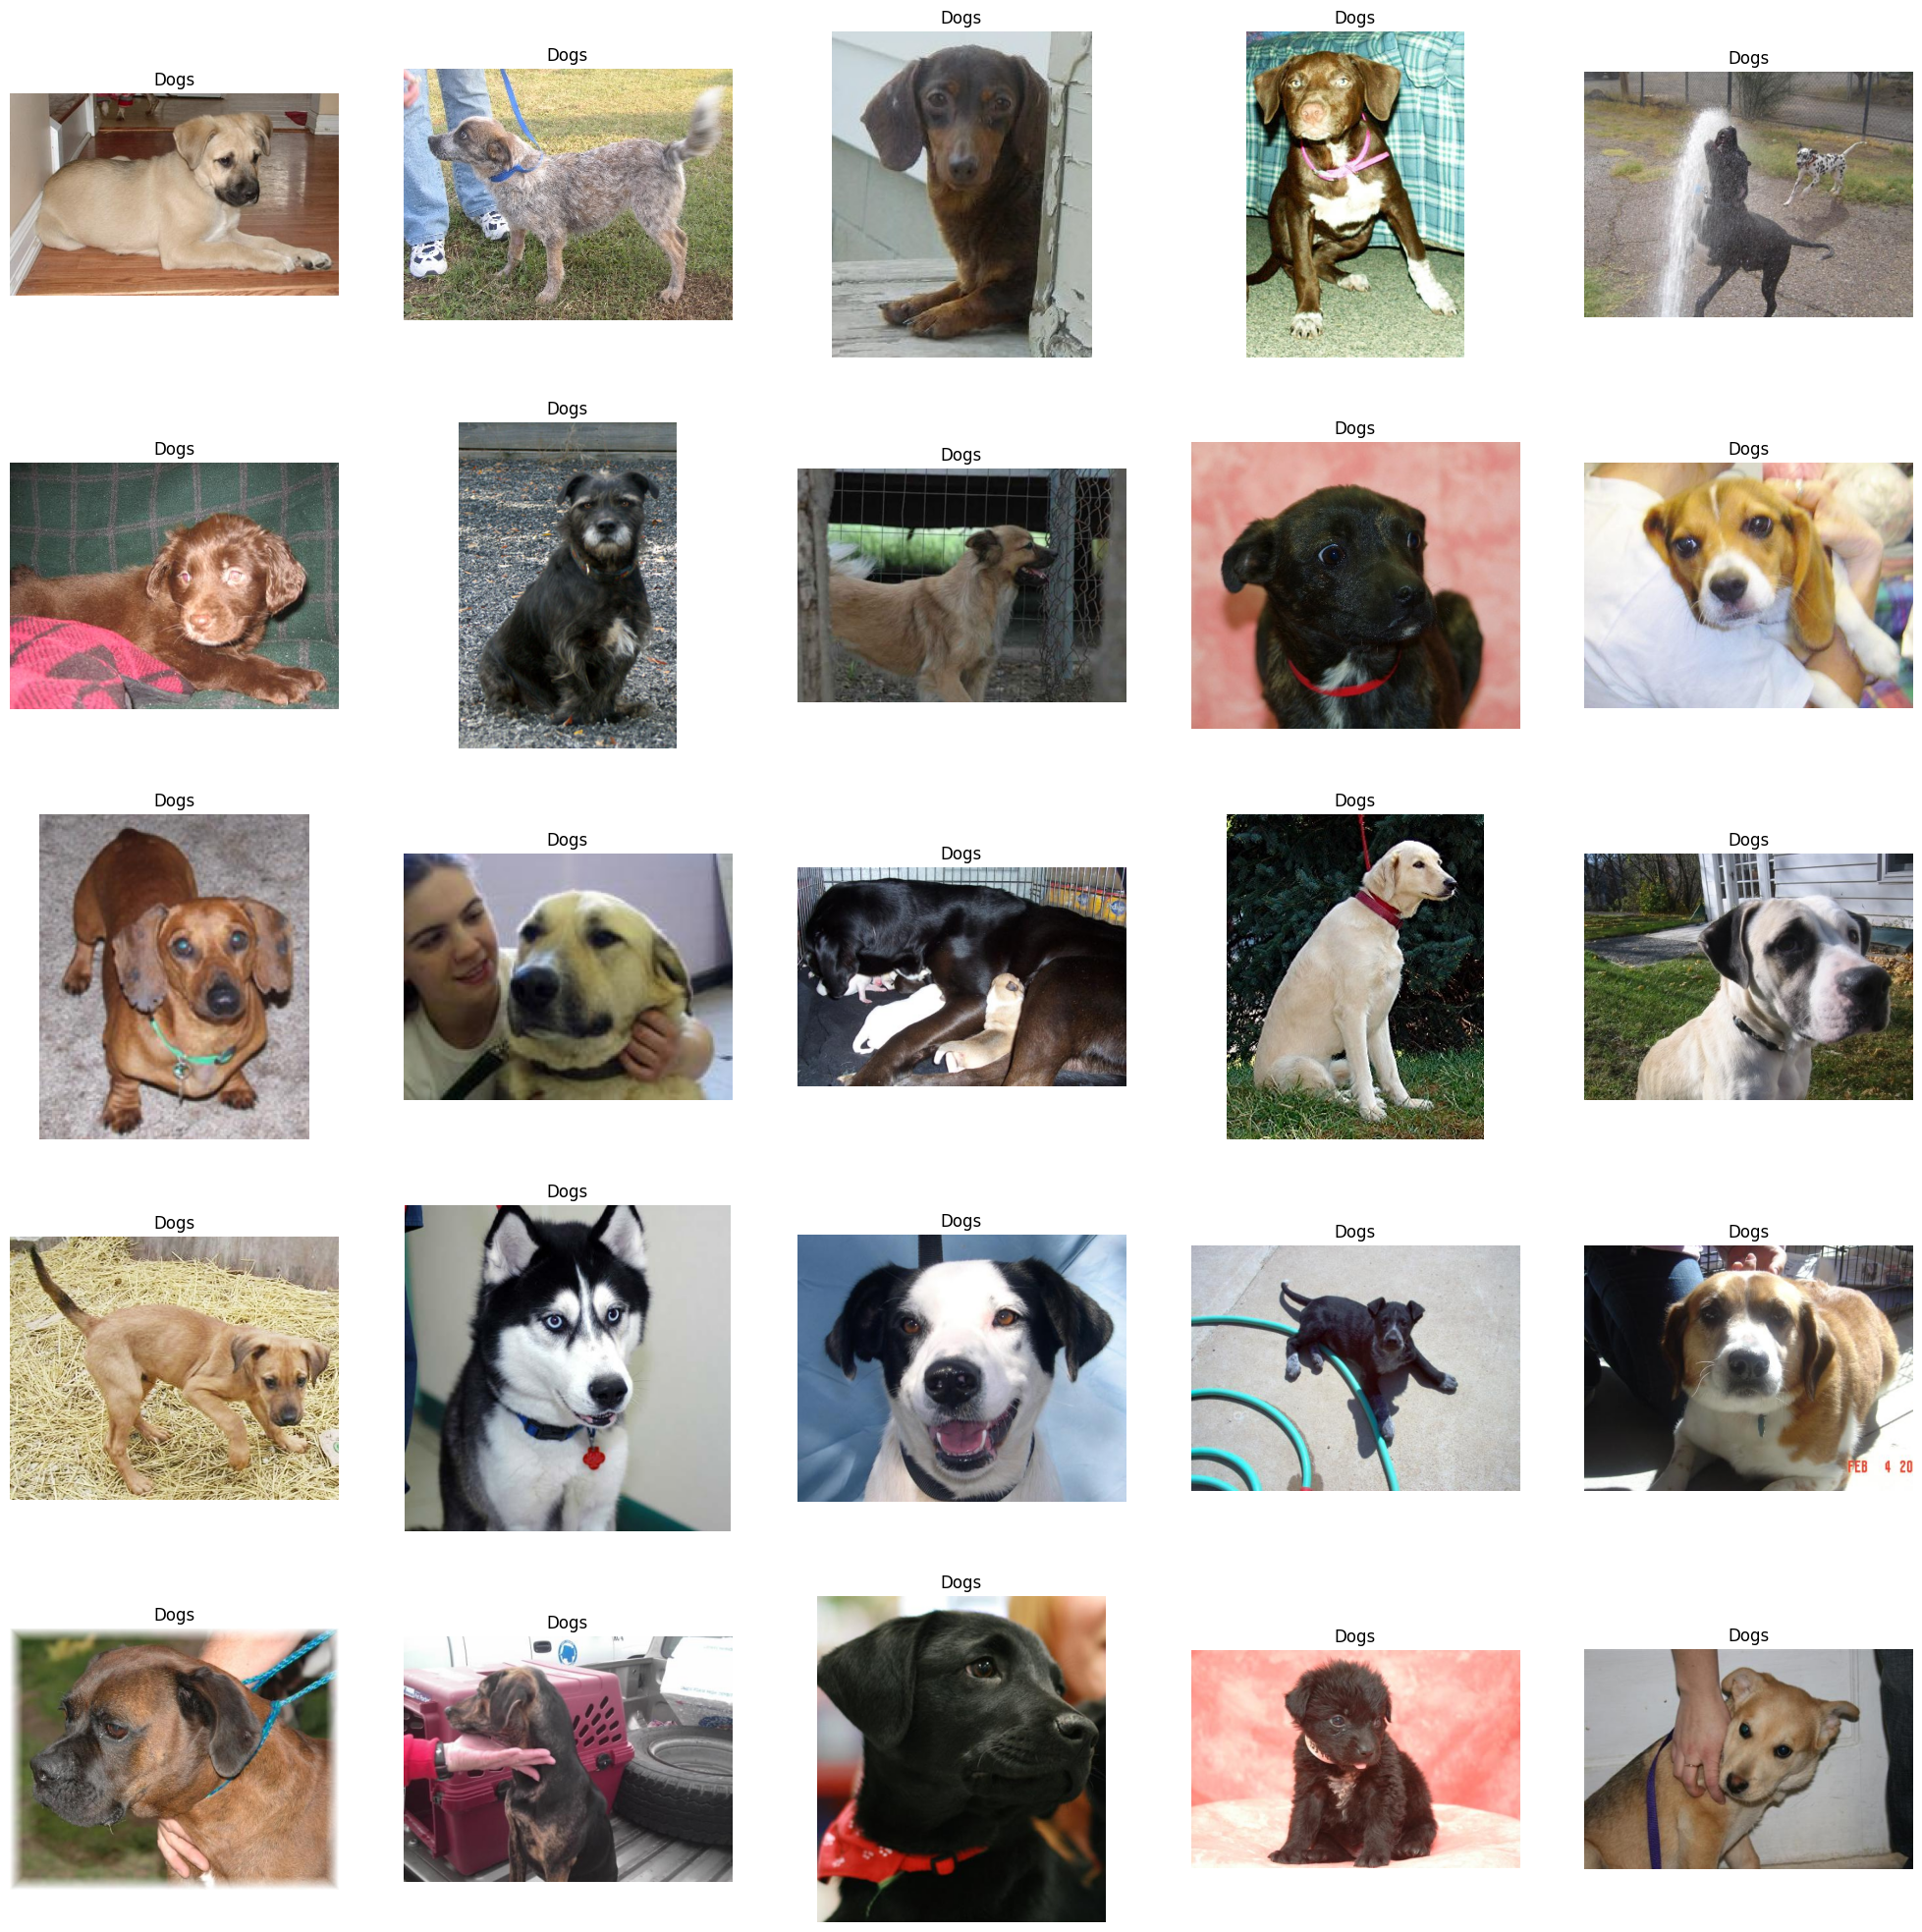

In [7]:
from tensorflow.keras.preprocessing.image import load_img

# to display grid of images 'Dogs'
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Dogs')
  plt.axis('off')

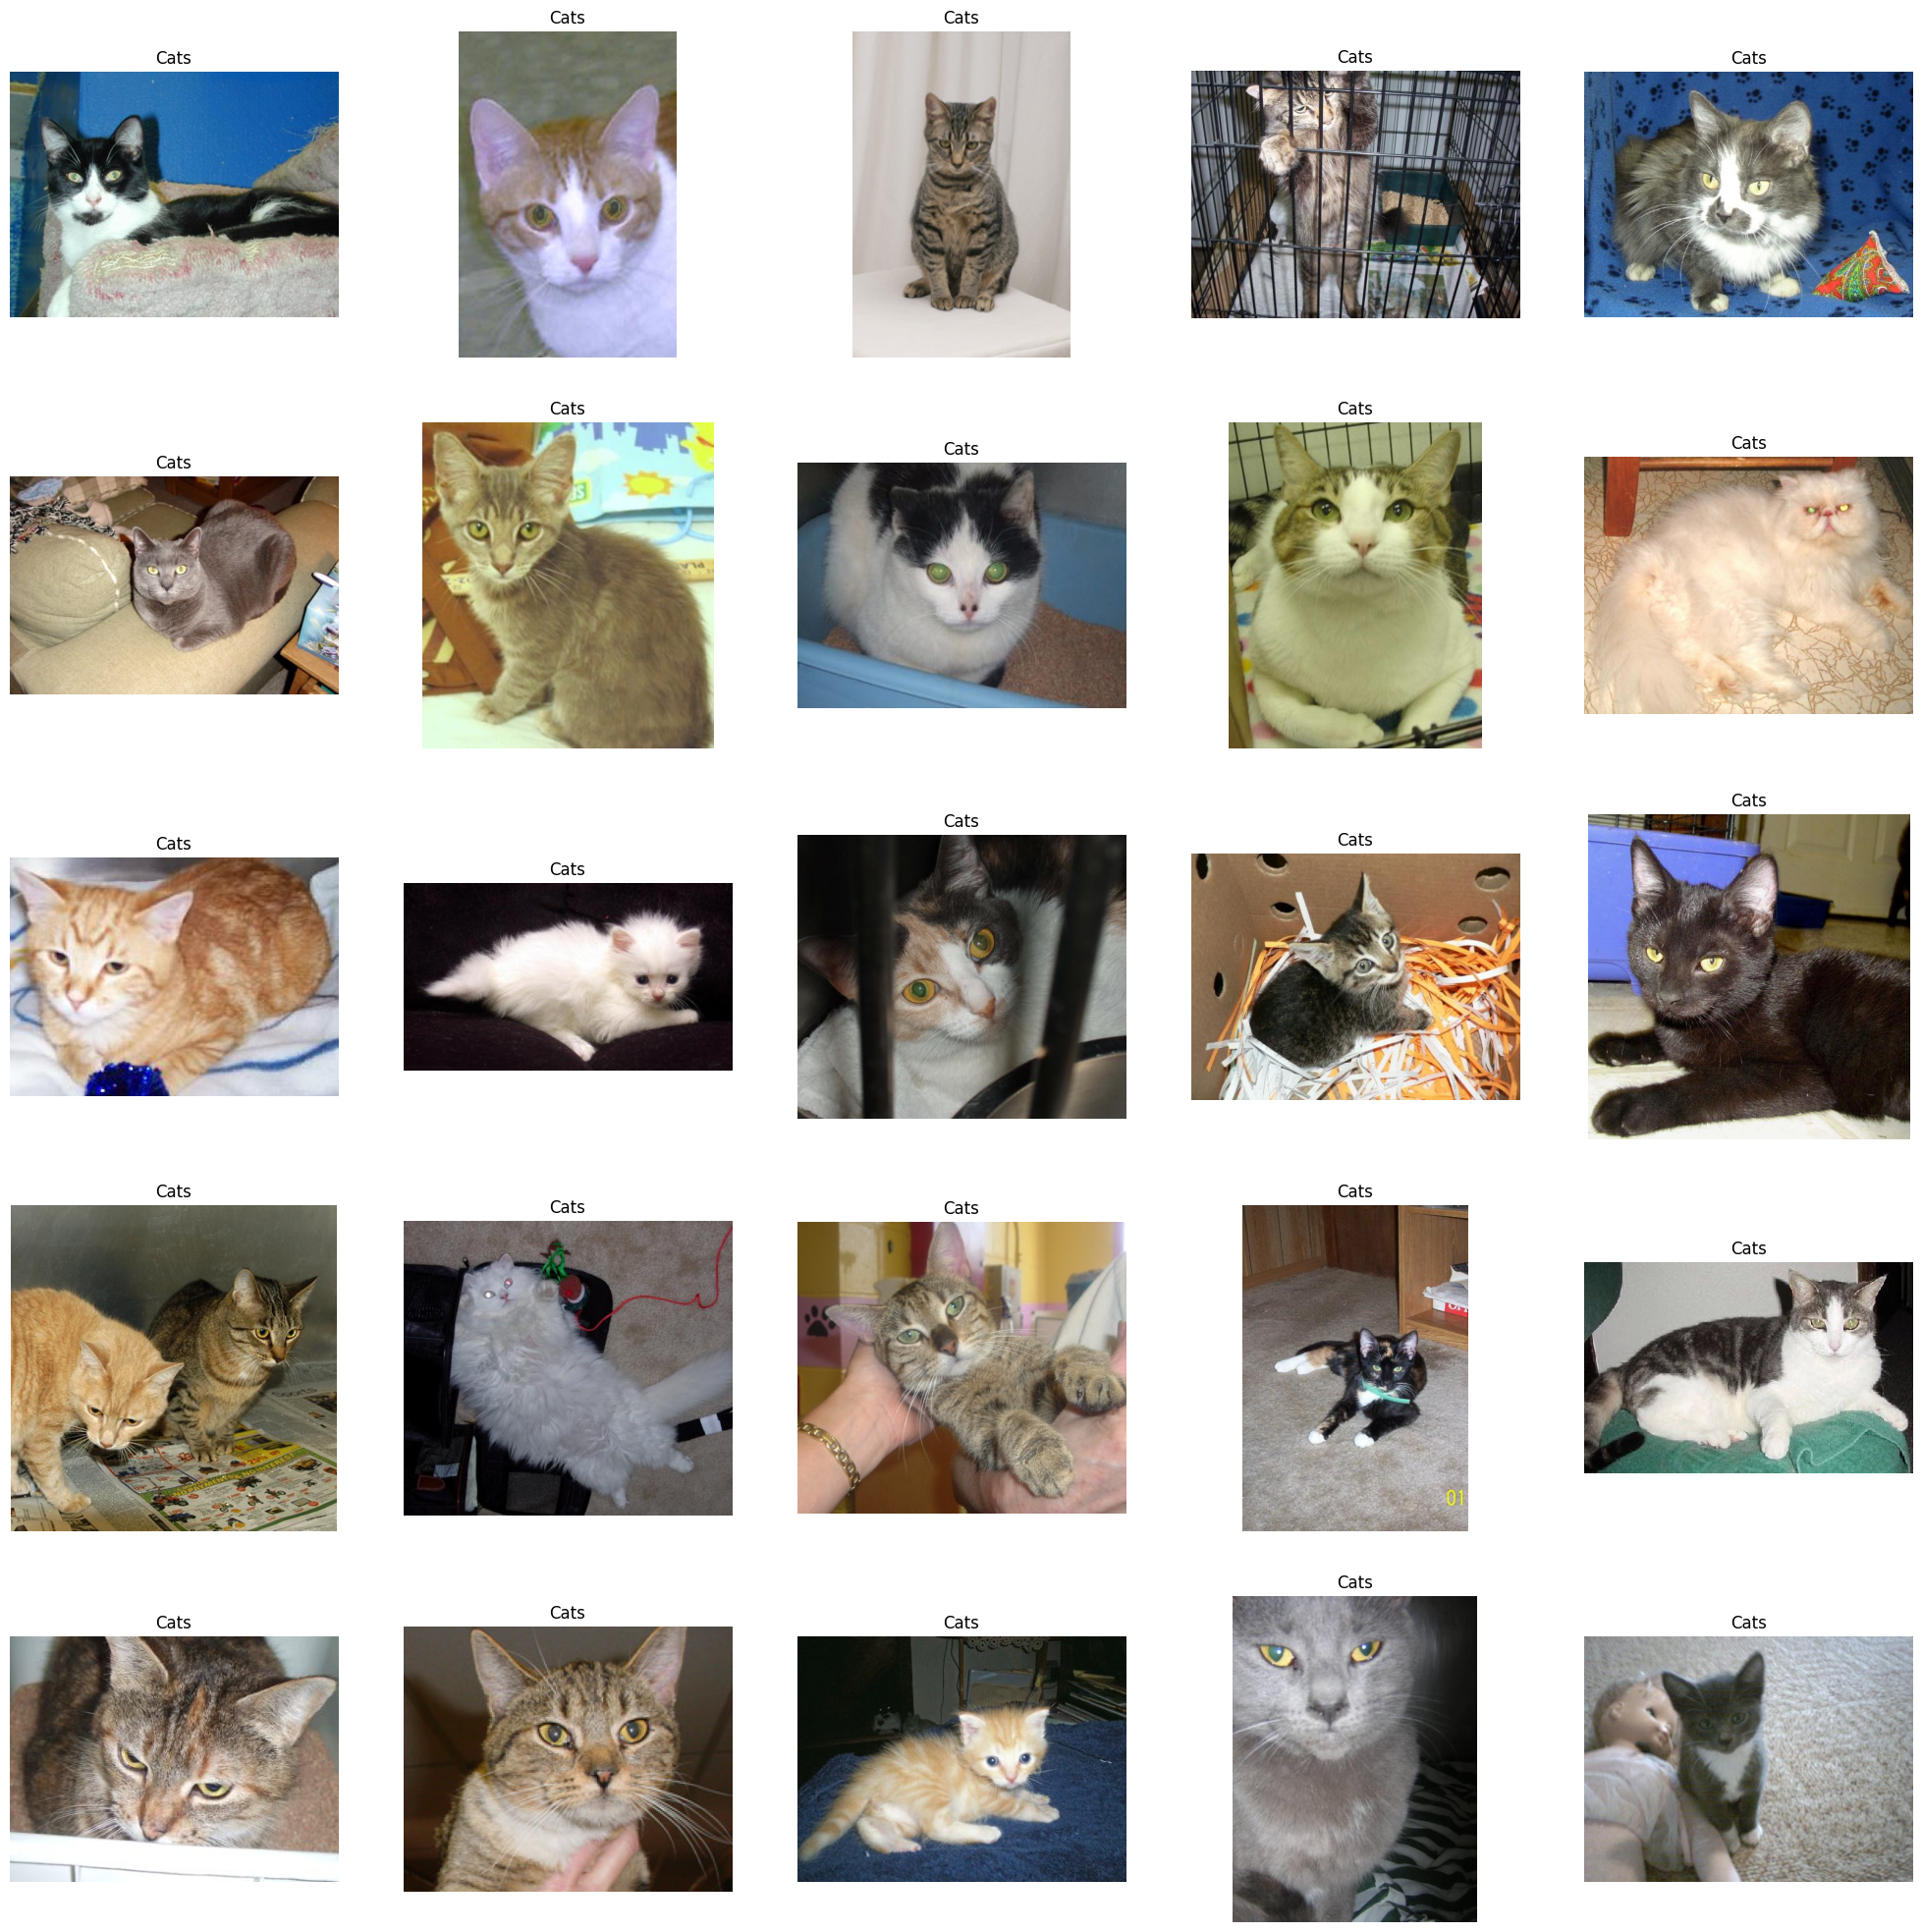

In [8]:
from tensorflow.keras.preprocessing.image import load_img

# to display grid of images 'Cats'
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Cats')
  plt.axis('off')

<Axes: ylabel='count'>

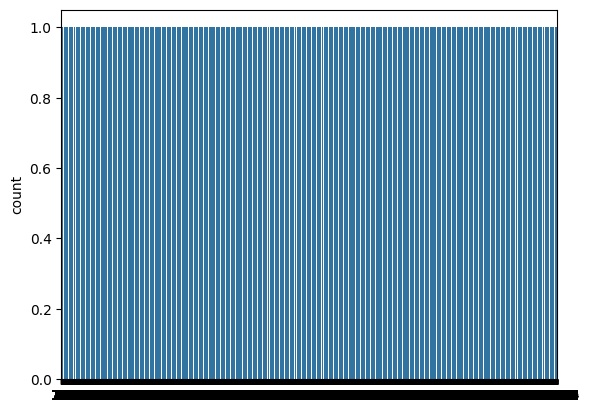

In [9]:
sns.countplot(df['label'])

## Create DataGenerator for the Images

In [10]:
df['label'] = df['label'].astype('str')
df.head()

images label
0   cats_and_dogs/PetImages\Dog\6519.jpg     1
1  cats_and_dogs/PetImages\Cat\10169.jpg     0
2   cats_and_dogs/PetImages\Dog\8263.jpg     1
3   cats_and_dogs/PetImages\Dog\2292.jpg     1
4   cats_and_dogs/PetImages\Dog\3396.jpg     1

In [12]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, # normalization of images
    rotation_range = 40, ## augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    # batch_size=16,
    class_mode='binary')

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    # batch_size=16,
    class_mode='binary')

print(len(train_iterator))
print(len(val_iterator))

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
40
10


## Model Creation

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

## Fit Model

In [16]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator) # normally 10 epochs

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.5372 - loss: 0.7311 - val_accuracy: 0.6606 - val_loss: 0.6186
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6641 - loss: 0.6119 - val_accuracy: 0.6904 - val_loss: 0.5713
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6925 - loss: 0.5824 - val_accuracy: 0.7220 - val_loss: 0.5448
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7165 - loss: 0.5523 - val_accuracy: 0.7496 - val_loss: 0.5092
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7351 - loss: 0.5262 - val_accuracy: 0.7556 - val_loss: 0.4993
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7561 - loss: 0.4979 - val_accuracy: 0.7708 - val_loss: 0.4758
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.7583 - loss: 0.4948 - val_accuracy: 0.7770 - val_loss: 0.4616
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.7742 - loss: 0.4615 - val_accuracy: 0.7546 - val_

## Save Model

In [17]:
model.save("my_model.keras")

## Load Model

In [18]:
from keras.models import load_model

model = load_model('my_model.keras')

## Visualization of Results

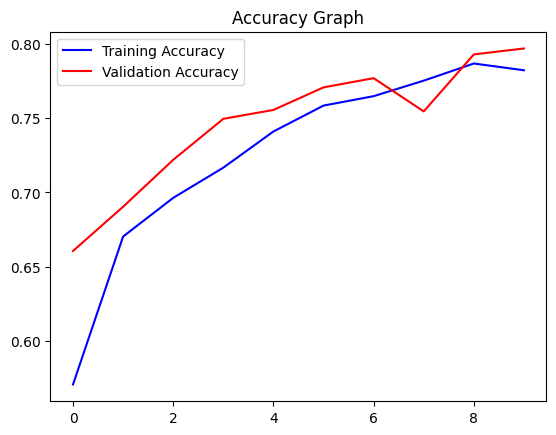

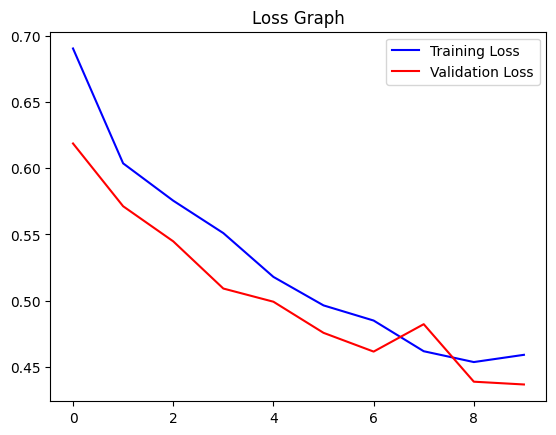

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Classificate own pictures


### Get the current working directory

In [20]:
current_directory = os.getcwd()

all_folders = []

for item in os.listdir(current_directory):
    full_path = os.path.join(current_directory, item)
    if os.path.isdir(full_path):
        all_folders.append(full_path)

for folder in all_folders:
    print(folder)


g:\Dogs-vs-Cats-Image-Classification\.git
g:\Dogs-vs-Cats-Image-Classification\.idea
g:\Dogs-vs-Cats-Image-Classification\Bilder_dogs_cats_test
g:\Dogs-vs-Cats-Image-Classification\cats_and_dogs
g:\Dogs-vs-Cats-Image-Classification\env
g:\Dogs-vs-Cats-Image-Classification\logs
g:\Dogs-vs-Cats-Image-Classification\pet_images
g:\Dogs-vs-Cats-Image-Classification\py_classes
g:\Dogs-vs-Cats-Image-Classification\random_pet_images
g:\Dogs-vs-Cats-Image-Classification\training_models
g:\Dogs-vs-Cats-Image-Classification\training_models_statistic
g:\Dogs-vs-Cats-Image-Classification\zip
g:\Dogs-vs-Cats-Image-Classification\__pycache__


### Check for Existing Images

In [21]:
directory_path = "Bilder_dogs_cats_test" 

full_paths = []

if os.path.exists(directory_path):
    for i_path in os.listdir(directory_path):
        full_path = os.path.join(directory_path, i_path)
        full_paths.append(full_path) 
else:
    print(f"The directory '{directory_path}' does not exist.")

for path in full_paths:
    print(path)


Bilder_dogs_cats_test\1280px-Hauskatze_langhaar.jpg
Bilder_dogs_cats_test\1691410387090,katze-184~_v-16x7@2dL_-594eb175bf96444e7f86c89c3d9f78feed295e4a (1).jpg
Bilder_dogs_cats_test\1691410387090,katze-184~_v-16x7@2dL_-594eb175bf96444e7f86c89c3d9f78feed295e4a.jpg
Bilder_dogs_cats_test\32279871-hunde-bellen-kommunikation-2vemEnE0TIec.jpg
Bilder_dogs_cats_test\aggressiver-hund--a232360481.jpg
Bilder_dogs_cats_test\boxer-hund--a75877846.jpg
Bilder_dogs_cats_test\csm_Hund-und-hitze_a857a5efac.jpg
Bilder_dogs_cats_test\csm_urlaub_hund-01_aa2e5743e2.jpg
Bilder_dogs_cats_test\dog_m5_exercise_dog_1_1614946074525.png
Bilder_dogs_cats_test\Ferie-med-hund-2-credit-Lourens-V.-Esch.jpg
Bilder_dogs_cats_test\grosser-hund-unterm-tisch.jpg
Bilder_dogs_cats_test\hund-gitter-tierheim-animal-welfare-1116205_1920-c-pixabay.jpg
Bilder_dogs_cats_test\hund-haustier-baby.jpg
Bilder_dogs_cats_test\hund-im-buero.jpg
Bilder_dogs_cats_test\Hund-Wildblumen-760x570.jpg
Bilder_dogs_cats_test\Hund.jpg
Bilder_dogs_cat

### Import Images

In [22]:
from keras.preprocessing import image

directory_path = "Bilder_dogs_cats_test/" 

testing_array = []
full_paths = []
testing_img = []
prediction_array = []

for i_path in os.listdir(directory_path):
  try:
    full_path = directory_path +  i_path
    if os.path.isfile(full_path): 
      full_paths.append(full_path)
      img = image.load_img(full_path, target_size=(128, 128))
      testing_img.append(img)
  except Exception as e:
    print("An error occurred: " + full_path, e)

print(os.listdir(directory_path))
print(full_paths)

['1280px-Hauskatze_langhaar.jpg', '1691410387090,katze-184~_v-16x7@2dL_-594eb175bf96444e7f86c89c3d9f78feed295e4a (1).jpg', '1691410387090,katze-184~_v-16x7@2dL_-594eb175bf96444e7f86c89c3d9f78feed295e4a.jpg', '32279871-hunde-bellen-kommunikation-2vemEnE0TIec.jpg', 'aggressiver-hund--a232360481.jpg', 'boxer-hund--a75877846.jpg', 'csm_Hund-und-hitze_a857a5efac.jpg', 'csm_urlaub_hund-01_aa2e5743e2.jpg', 'dog_m5_exercise_dog_1_1614946074525.png', 'Ferie-med-hund-2-credit-Lourens-V.-Esch.jpg', 'grosser-hund-unterm-tisch.jpg', 'hund-gitter-tierheim-animal-welfare-1116205_1920-c-pixabay.jpg', 'hund-haustier-baby.jpg', 'hund-im-buero.jpg', 'Hund-Wildblumen-760x570.jpg', 'Hund.jpg', 'Hund.png', 'hund21j3kl.jpg', 'hund23.jpg', 'hund23432.jpg', 'hund235.jpg', 'Hunde-Baden.jpg', 'hunde-gegen-depressionen.jpg', 'hunde-genmutation--a148226828.jpg', 'hundejklöj234.jpg', 'hundejkölj234.jpg', 'hundejökj23.jpg', 'hundejölk2.jpg', 'hundewelpe--a310911521.jpg', 'Hunde_Marion Terhaar.jpg.jpg', 'hundj45l.jpg

## Prediction

In [23]:
iteration = 0
trueCalculation = 0
falseCalculation = 0
false_calculation_path = []

for i in range(len(testing_img)-1):
  if os.path.isfile(full_paths[i]):
    iteration = iteration +1
    img = image.load_img(full_paths[i], target_size=(128,128))
    img_array = image.img_to_array(img) / 255. # convert img to Numpy-Array
    img_array = np.expand_dims(img_array, axis=0) # add dimension

    prediction = model.predict(img_array) # predict
    prediction_array.append(prediction)

    if prediction_array[i] < 0.5:
      print("The image is probably a cat.")
      if 'katz' in full_paths[i] or 'cat' in full_paths[i] or 'Katz' in full_paths[i] or 'Cat' in full_paths[i] or '' in full_paths[i] or 'Katze' in full_paths[i]:
        trueCalculation = trueCalculation +1
      else:
        falseCalculation = falseCalculation +1
        false_calculation_path.append(full_paths[i])

    else:
      if 'hund' in full_paths[i] or 'dog' in full_paths[i] or 'Hund' in full_paths[i] or 'Dog' in full_paths[i]:
        trueCalculation = trueCalculation +1
      else:
        falseCalculation = falseCalculation +1
        false_calculation_path.append(full_paths[i])
      print("The image is probably a dog.")
    print(prediction_array[i])
    print(full_paths[i])
    print('----------------')

  input_path = []
  label = []

print("Iterations: " + str(iteration))
print("Correct Prediction:" + str(trueCalculation))
print("Incorrect Prediction:" + str(falseCalculation))
print("Incorrect Prediction Paths: " + str(false_calculation_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
The image is probably a cat.
[[0.03232439]]
Bilder_dogs_cats_test/1280px-Hauskatze_langhaar.jpg
----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The image is probably a cat.
[[0.10141819]]
Bilder_dogs_cats_test/1691410387090,katze-184~_v-16x7@2dL_-594eb175bf96444e7f86c89c3d9f78feed295e4a (1).jpg
----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
The image is probably a cat.
[[0.10141819]]
Bilder_dogs_cats_test/1691410387090,katze-184~_v-16x7@2dL_-594eb175bf96444e7f86c89c3d9f78feed295e4a.jpg
----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The image is probably a dog.
[[0.9764916]]
Bilder_dogs_cats_test/32279871-hunde-bellen-kommunikation-2vemEnE0TIec.jpg
----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The image is probably a cat.
[[0.4868675]]
Bilder_dogs_cats_test/aggressiver-hund--a232360481.jpg
----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The image is probably a dog.
[[0.866138]]
Bilder_dogs_cats_test/boxer-hund-

### Incorrect Prediction

In [24]:
print(len(false_calculation_path))


for i in range(len(false_calculation_path)-1):
  if os.path.isfile(false_calculation_path[i]):
    iteration = iteration +1
    img = image.load_img(false_calculation_path[i], target_size=(128,128))
    img_array = image.img_to_array(img) / 255. # convert img to Numpy-Array
    img_array = np.expand_dims(img_array, axis=0) # add dimension

    prediction = model.predict(img_array) # predict
    prediction_array.append(prediction)

    if prediction_array[i] < 0.5:
      print("The image is probably a cat.")
      if 'katz' in false_calculation_path[i] or 'cat' in false_calculation_path[i] or 'Katz' in false_calculation_path[i] or 'Cat' in false_calculation_path[i]:
        trueCalculation = trueCalculation +1
      else:
        falseCalculation = falseCalculation +1
        false_calculation_path.append(false_calculation_path[i])

    else:
      if 'hund' in false_calculation_path[i] or 'dog' in false_calculation_path[i] or 'Hund' in false_calculation_path[i] or 'Dog' in false_calculation_path[i]:
        trueCalculation = trueCalculation +1
      else:
        falseCalculation = falseCalculation +1
        false_calculation_path.append(false_calculation_path[i])
      print("The image is probably a dog.")
    print(prediction_array[i])
    print(full_paths[i])
    print('----------------')

0
